# Exploratory Data Analysis

Import neccessary packages

In [2]:
from pathlib import Path
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import shutil
import hashlib
from collections import defaultdict
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim

## Data Quality Checks
The code cell below is making sure all images are in the same file format and same color mode.

In [3]:
# Notebook is in notebooks/
# Data is in ../data/interim/
# Make sure to adjust the path accordingly
DATA_DIR = Path("../data/raw/unzipped_raw_data")

# Making sure all images same format
extensions = []

for path in DATA_DIR.rglob("*"):
    if path.is_file():
        extensions.append(path.suffix.lower())

extension_counts = Counter(extensions)

# image mode
image_paths = list(DATA_DIR.rglob("*.jpg"))
modes = []
for img_path in tqdm(image_paths, desc="Checking image color modes"):
    with Image.open(img_path) as img:
        modes.append(img.mode)

mode_counts = Counter(modes)
print(mode_counts)
print(extension_counts)

Checking image color modes: 100%|██████████| 25553/25553 [00:00<00:00, 36995.10it/s]

Counter({'RGB': 25553})
Counter({'.jpg': 25553, '': 11, '.yaml': 1})


All images are .jpg format and are in RGB mode.

### File corruption
`img.verify()` from `PIL` scans the images in all subdirectories for corrupt files.

In [4]:
DATA_DIR = Path("../data/raw/unzipped_raw_data")

image_paths = list(DATA_DIR.rglob("*.jpg"))

corrupt_images = []

for img_path in tqdm(image_paths, desc="Checking images"):
    try:
        with Image.open(img_path) as img:
            img.verify()  
    except Exception:
        corrupt_images.append(img_path)

print(f"Total images checked: {len(image_paths)}")
print(f"Corrupt images found: {len(corrupt_images)}")

Checking images: 100%|██████████| 25553/25553 [00:00<00:00, 37510.60it/s]

Total images checked: 25553
Corrupt images found: 0


### Duplicates
The next code cell use md5 hash function to identify duplicate files in the datasets.

In [5]:
DATA_DIR = Path("../data/raw/unzipped_raw_data")

image_paths = list(DATA_DIR.rglob("*.jpg"))

def file_md5(path, chunk_size=8192):
    md5 = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(chunk_size), b""):
            md5.update(chunk)
    return md5.hexdigest()

hash_to_paths = defaultdict(list)

for p in tqdm(image_paths, desc="Hashing files"):
    h = file_md5(p)
    hash_to_paths[h].append(p)

# Keep only hashes with more than one file (true duplicates)
file_duplicates = {
    h: paths for h, paths in hash_to_paths.items() if len(paths) > 1
}

print(f"File-level duplicate groups: {len(file_duplicates)}")


Hashing files: 100%|██████████| 25553/25553 [00:04<00:00, 5552.48it/s] 

File-level duplicate groups: 5591


Surprisingly, the method found 5591 pair of duplicate files. This was confirmed manually.
Next code chunk creates a dataframe for the duplicate files with information about their path, split and class.
Using this information, a decision can be made to see if any logic can be applied to save as much data as possible.

In [6]:
rows = []

for h, paths in file_duplicates.items():
    if len(paths) >= 2:
        rows.append({
            "hash": h,
            "num_files": len(paths),
            "path_1": str(paths[0]),
            "path_2": str(paths[1])
        })

file_duplicates_pair_df = pd.DataFrame(rows)

def extract_split_and_class(path_str):
    path = Path(path_str)
    parts = path.parts
    idx = parts.index("unzipped_raw_data")
    split = parts[idx + 1]
    cls = parts[idx + 2]
    return split, cls

# Apply extraction
file_duplicates_pair_df[["split_1", "class_1"]] = (
    file_duplicates_pair_df["path_1"]
    .apply(lambda p: pd.Series(extract_split_and_class(p)))
)

file_duplicates_pair_df[["split_2", "class_2"]] = (
    file_duplicates_pair_df["path_2"]
    .apply(lambda p: pd.Series(extract_split_and_class(p)))
)


file_duplicates_pair_df.to_csv("../data/interim/file_duplicates.csv", index=False)
file_duplicates_pair_df

,hash,num_files,path_1,path_2,split_1,class_1,split_2,class_2
0,5cd88f93817d8ad7203345747613ddd8,2,../data/raw/unzipped_raw_data/test/normal/norm...,../data/raw/unzipped_raw_data/train/tuberculos...,test,normal,train,tuberculosis
1,b7decde86a97411de05f96cf8aeae544,2,../data/raw/unzipped_raw_data/test/normal/norm...,../data/raw/unzipped_raw_data/train/pneumonia/...,test,normal,train,pneumonia
2,36d1e38cc3293841e3c221229695420e,2,../data/raw/unzipped_raw_data/test/normal/norm...,../data/raw/unzipped_raw_data/train/pneumonia/...,test,normal,train,pneumonia
3,afce02b448fd06d3bc81065e31bd91f0,2,../data/raw/unzipped_raw_data/test/normal/norm...,../data/raw/unzipped_raw_data/train/tuberculos...,test,normal,train,tuberculosis
4,790e2ea9208f08d4191aa9759fa079c9,2,../data/raw/unzipped_raw_data/test/normal/norm...,../data/raw/unzipped_raw_data/test/tuberculosi...,test,normal,test,tuberculosis
...,...,...,...,...,...,...,...,...
5586,2512fafcefc442b31127f14d5addc076,2,../data/raw/unzipped_raw_data/val/normal/norma...,../data/raw/unzipped_raw_data/val/tuberculosis...,val,normal,val,tuberculosis
5587,682b28b90f797032e71287b13c25997d,2,../data/raw/unzipped_raw_data/val/normal/norma...,../data/raw/unzipped_raw_data/val/tuberculosis...,val,normal,val,tuberculosis
5588,fbd068cb6a6dd20287e238e6c12ac226,2,../data/raw/unzipped_raw_data/val/normal/norma...,../data/raw/unzipped_raw_data/val/tuberculosis...,val,normal,val,tuberculosis
5589,91cb5ddb940bec37c67894b58631cda7,2,../data/raw/unzipped_raw_data/val/normal/norma...,../data/raw/unzipped_raw_data/val/tuberculosis...,val,normal,val,tuberculosis


Unfortunately, any logic to delete one of the duplicates arbritaly will not be supported by any evidence. Two of the same image with two different classes, one of them must be wrong! Keeping the image with the wrong label will have high cost on the training. My thougths now are to be keep only duplicates with the same class.

In [7]:
same_class_df = file_duplicates_pair_df[
    file_duplicates_pair_df["class_1"] == file_duplicates_pair_df["class_2"]
    
]

same_class_df 

,hash,num_files,path_1,path_2,split_1,class_1,split_2,class_2
594,0c0a0c84e6703607bf94a9f5a60cfe6c,2,../data/raw/unzipped_raw_data/test/tuberculosi...,../data/raw/unzipped_raw_data/val/tuberculosis...,test,tuberculosis,val,tuberculosis
5123,8d5989c65553767d9aaa58694d21818c,2,../data/raw/unzipped_raw_data/train/tuberculos...,../data/raw/unzipped_raw_data/train/tuberculos...,train,tuberculosis,train,tuberculosis
5590,438bb76c5106fe5e40ef49901f1a93e6,2,../data/raw/unzipped_raw_data/val/tuberculosis...,../data/raw/unzipped_raw_data/val/tuberculosis...,val,tuberculosis,val,tuberculosis


Ok. It turned out, only 3 duplicates have the same class. I will prioritze to keep images (if same class)  from train then val then test. 

In [8]:
# create a new directory for deduped data
# SRC_DIR = Path("../data/interim")
# DST_DIR = Path("../data/interim_deduped")

# if not DST_DIR.exists():
#     shutil.copytree(SRC_DIR, DST_DIR)

# Set split priority
SPLIT_PRIORITY = {"train": 0, "val": 1, "test": 2}

paths_to_delete = []

for _, row in file_duplicates_pair_df.iterrows():
    p1, p2 = row["path_1"], row["path_2"]

    # Case 1: conflicting classes → delete both
    if row["class_1"] != row["class_2"]:
        paths_to_delete.extend([p1, p2])
        continue

    # Case 2: same class
    if row["split_1"] == row["split_2"]:
        # delete whichever comes first alphabetically; this so it is reproducible!
        delete_path = min(p1, p2)
    else:
        # keep by split priority: train > val > test
        keep_path = (
            p1 if SPLIT_PRIORITY[row["split_1"]] < SPLIT_PRIORITY[row["split_2"]] else p2
        )
        delete_path = p2 if keep_path == p1 else p1

    paths_to_delete.append(delete_path)

# Perform deletion only in the copied dataset
# deleted = 0
# for p in paths_to_delete:
#     fp = Path(p.replace("data/interim", "data/interim_deduped"))
#     if fp.exists():
#         fp.unlink()
#         deleted += 1

# print(f"Deleted {deleted} files from interim_deduped.")

len(paths_to_delete)


11179

### Image Quality 
In the code cell below, I calculate laplacian variance, signal-to-noise ratio and RMS contrast for all images. The purpose of this is to flag images that may exhibit bluriness or excessive noise. I hesitate with medical images to exclude images just based on numerical threshold only because of the extreme variations and the lack of reference. So visual inspection is used as the final decision step before any exclusion, ensuring that clinically/anatomically interpretable images are removed.

In [9]:
DATA_DIR = Path("../data/raw/unzipped_raw_data")
image_paths = list(DATA_DIR.rglob("*.jpg"))

records = []

for p in tqdm(image_paths, desc="Computing image quality metrics"):
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    laplacian_var = cv2.Laplacian(img, cv2.CV_64F).var()
    rms_contrast = img.std()
    noise = rms_contrast
    snr = img.mean() / noise if noise > 0 else np.nan

    records.append({
        "path": str(p),
        "laplacian_var": laplacian_var,
        "snr": snr,
        "rms_contrast": rms_contrast
    })

image_quality_df = pd.DataFrame(records)
image_quality_df.to_csv("../data/interim/image_quality_metrics.csv", index=False)
image_quality_df.head()

Computing image quality metrics: 100%|██████████| 25553/25553 [04:06<00:00, 103.87it/s]


,path,laplacian_var,snr,rms_contrast
0,../data/raw/unzipped_raw_data/test/normal/norm...,61.007967,1.784835,68.974630
1,../data/raw/unzipped_raw_data/test/normal/norm...,176.739283,3.147335,53.216927
2,../data/raw/unzipped_raw_data/test/normal/norm...,107.312978,2.048281,64.144415
3,../data/raw/unzipped_raw_data/test/normal/norm...,176.581322,2.447373,47.344382
4,../data/raw/unzipped_raw_data/test/normal/norm...,284.730246,2.191697,72.668029


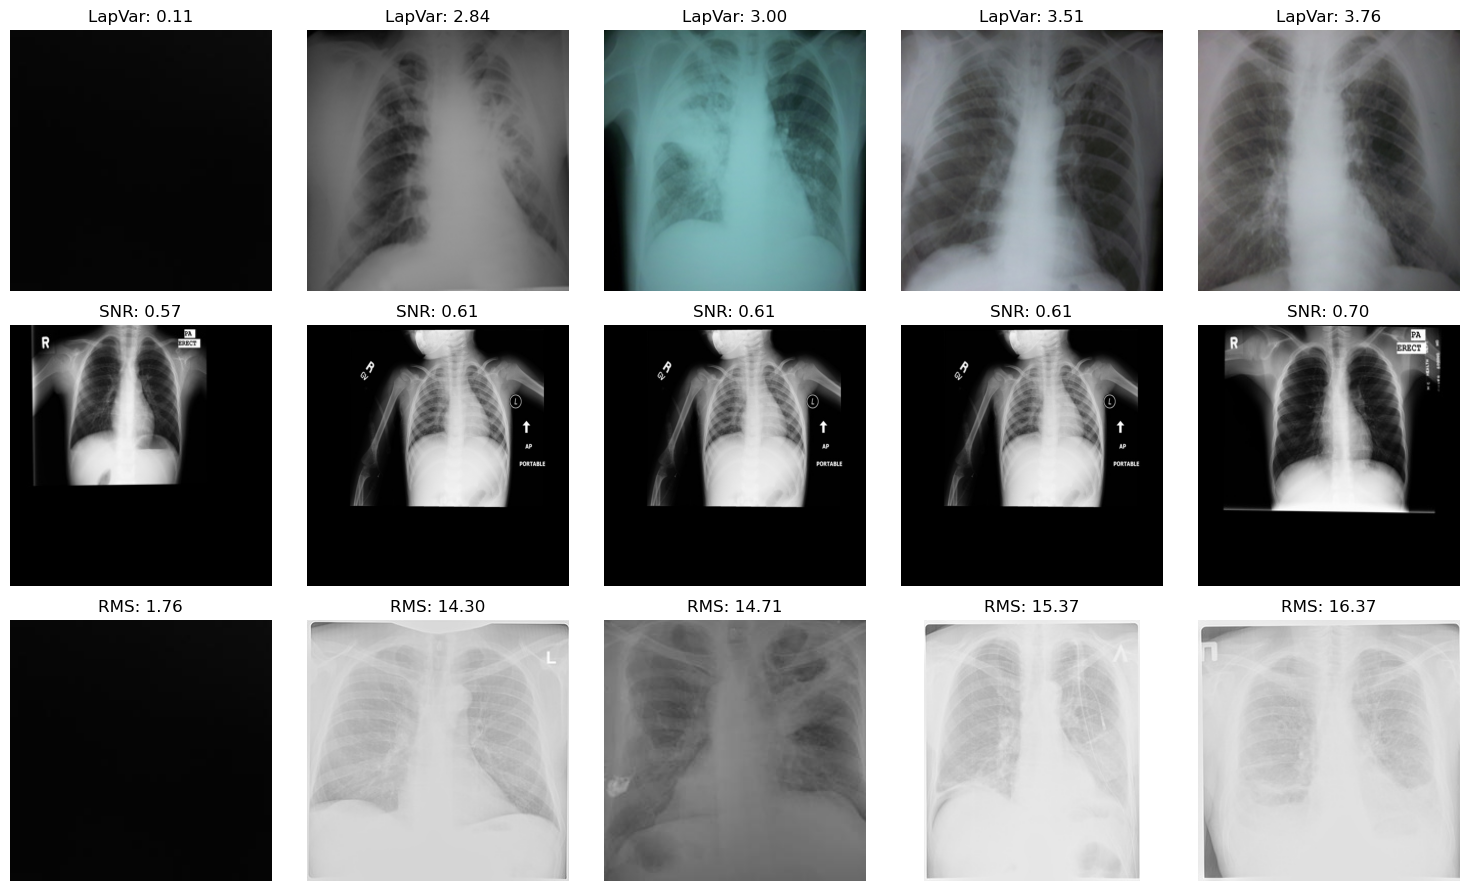

In [10]:

# Select lowest 5 for each metric
lowest_lap = image_quality_df.sort_values("laplacian_var").head(5)
lowest_snr = image_quality_df.sort_values("snr").head(5)
lowest_rms = image_quality_df.sort_values("rms_contrast").head(5)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# Row 1: Lowest Laplacian variance
for ax, (_, row) in zip(axes[0], lowest_lap.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"LapVar: {row['laplacian_var']:.2f}")
    ax.axis("off")

# Row 2: Lowest SNR
for ax, (_, row) in zip(axes[1], lowest_snr.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"SNR: {row['snr']:.2f}")
    ax.axis("off")

# Row 3: Lowest RMS contrast
for ax, (_, row) in zip(axes[2], lowest_rms.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"RMS: {row['rms_contrast']:.2f}")
    ax.axis("off")

axes[0, 0].set_ylabel("Lowest Laplacian", fontsize=12)
axes[1, 0].set_ylabel("Lowest SNR", fontsize=12)
axes[2, 0].set_ylabel("Lowest RMS", fontsize=12)

plt.tight_layout()
plt.show()

# lowest LapVar and Lowest SNR are the same image.

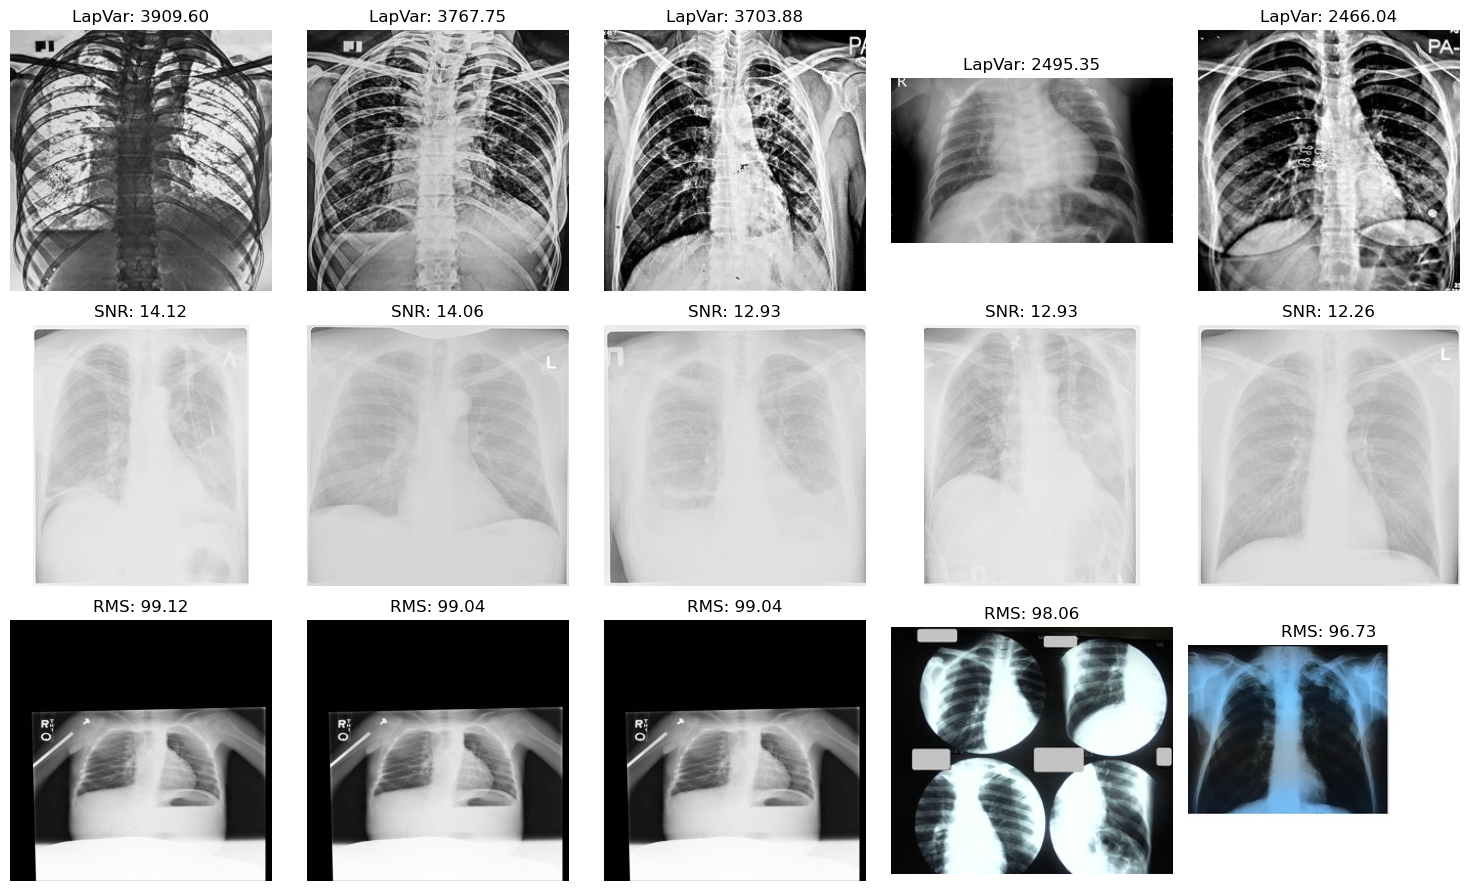

In [11]:
#  highest 5 for each metric
highest_lap = image_quality_df.sort_values("laplacian_var", ascending=False).head(5)
highest_snr = image_quality_df.sort_values("snr", ascending=False).head(5)
highest_rms = image_quality_df.sort_values("rms_contrast",  ascending=False).head(5)

fig, axes = plt.subplots(3, 5, figsize=(15, 9))

# row 1: Highest Laplacian variance
for ax, (_, row) in zip(axes[0], highest_lap.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"LapVar: {row['laplacian_var']:.2f}")
    ax.axis("off")

# row 2: Highest SNR
for ax, (_, row) in zip(axes[1], highest_snr.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"SNR: {row['snr']:.2f}")
    ax.axis("off")

# row 3: Highest RMS contrast
for ax, (_, row) in zip(axes[2], highest_rms.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"RMS: {row['rms_contrast']:.2f}")
    ax.axis("off")

axes[0, 0].set_ylabel("Highest Laplacian", fontsize=12)
axes[1, 0].set_ylabel("Highest SNR", fontsize=12)
axes[2, 0].set_ylabel("Highest RMS", fontsize=12)

plt.tight_layout()
plt.show()

I will delete the single image that has lowest SNR and lowest lap_var. It is completely black. And also, the two images with the highest RMS constrast. So three images.

In [12]:
# Get the single worst image by Laplacian and RMS
worst_lap_path = image_quality_df.sort_values("laplacian_var").iloc[0]["path"]
worst_rms_path = image_quality_df.sort_values("rms_contrast").iloc[0]["path"]


paths_to_delete.extend([worst_lap_path, worst_rms_path])
len(paths_to_delete)

# paths_to_delete = set([worst_lap_path, worst_rms_path])

# paths_to_delete.update(
#     image_quality_df.sort_values("rms_contrast", ascending=False)
#     .head(2)["path"]
# )

# paths_to_delete

# deleted = 0

# for p in paths_to_delete:
#     fp = Path(p)
#     if fp.exists():
#         fp.unlink()
#         deleted += 1
# print(f"Deleted {deleted} images")

11181

Next code cell assess blockiness that happens due to image compression. they are used here to flag images for inspection.

In [13]:
def blockiness_index(img):
    h, w = img.shape
    h8, w8 = (h//8)*8, (w//8)*8
    img8 = img[:h8, :w8].reshape(h8//8, 8, w8//8, 8)
    diffs = np.abs(img8[:, :-1, :, :] - img8[:, 1:, :, :]).mean()
    return diffs

records = []
for p in tqdm(image_paths):
    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None or img.shape[0] < 16 or img.shape[1] < 16:
        continue
    bi = blockiness_index(img)
    records.append({"path": str(p), "blockiness": bi})

block_df = pd.DataFrame(records)
block_df.to_csv("../data/interim/image_blockiness_metrics.csv", index=False)

block_df.head()


100%|██████████| 25553/25553 [02:35<00:00, 164.65it/s]


,path,blockiness
0,../data/raw/unzipped_raw_data/test/normal/norm...,97.473154
1,../data/raw/unzipped_raw_data/test/normal/norm...,102.666146
2,../data/raw/unzipped_raw_data/test/normal/norm...,103.395790
3,../data/raw/unzipped_raw_data/test/normal/norm...,88.819374
4,../data/raw/unzipped_raw_data/test/normal/norm...,99.363299


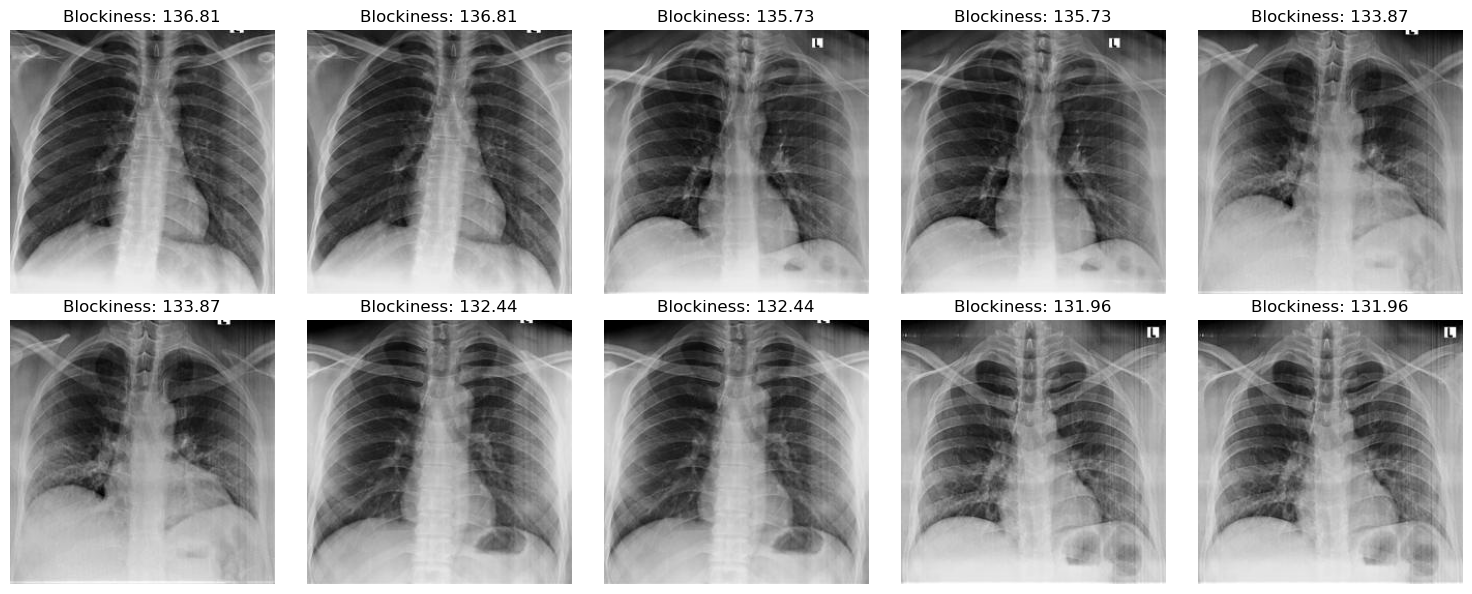

In [14]:

top_block_df = block_df.sort_values("blockiness", ascending=False).head(10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.flatten(), top_block_df.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Blockiness: {row['blockiness']:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Upon visual inspection, images with high blockiness values are still usable and anatomy is visible. I will not exclude based on blockiness.

### Image size
Inspecting image size and aspect ratio.

In [15]:
DATA_DIR = Path("../data/raw/unzipped_raw_data")

records = []

image_paths = list(DATA_DIR.rglob("*.jpg"))

for p in tqdm(image_paths, desc="Reading image sizes"):
    with Image.open(p) as img:
        width, height = img.size
        parts = p.parts
        idx = parts.index("unzipped_raw_data")
        split = parts[idx + 1]
        cls = parts[idx + 2]

        records.append({
            "path": str(p),
            "split": split,
            "class": cls,
            "width": width,
            "height": height,
            "aspect_ratio": width / height,
            "area": width * height
        })

sizes_df = pd.DataFrame(records)
sizes_df.head()


sizes_df.to_csv("../data/interim/image_sizes.csv", index=False)
sizes_df.head()


Reading image sizes: 100%|██████████| 25553/25553 [00:00<00:00, 28485.44it/s]


,path,split,class,width,height,aspect_ratio,area
0,../data/raw/unzipped_raw_data/test/normal/norm...,test,normal,1024,1024,1.000000,1048576
1,../data/raw/unzipped_raw_data/test/normal/norm...,test,normal,512,512,1.000000,262144
2,../data/raw/unzipped_raw_data/test/normal/norm...,test,normal,1822,1705,1.068622,3106510
3,../data/raw/unzipped_raw_data/test/normal/norm...,test,normal,1024,1024,1.000000,1048576
4,../data/raw/unzipped_raw_data/test/normal/norm...,test,normal,1024,1024,1.000000,1048576


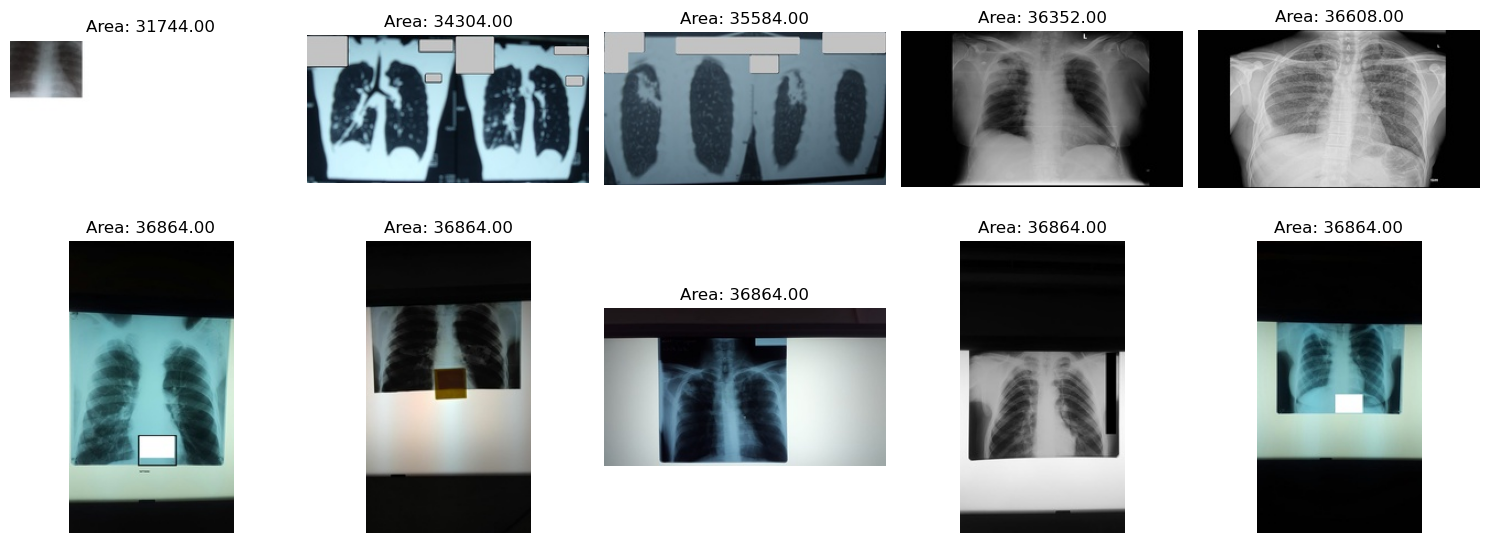

In [16]:
top_sizes_df = sizes_df.sort_values("area").head(10)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for ax, (_, row) in zip(axes.flatten(), top_sizes_df.iterrows()):
    img = Image.open(row["path"])
    ax.imshow(img, cmap="gray")
    ax.set_title(f"Area: {row['area']:.2f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

I will not exclude images based on area.  
Some images appear to have duplicate views. These images were retained, as lung anatomy and pathological features remained clearly visible. standard preprocessing steps are expected to reduce their impact.
Images aspect ratio ranges from from o.5 to 3.3. Visual inspection the extreme cases, it showed that they are still usable and lung anatomy still visible.

**Side note**: visual inspection showed inconsistent color channel intensities (mostly blue) across images. This motivates conversion to grayscale during preprocessing to standardize input representation and reduce channel-specific noise.

### Dark or over-exposed images

In [17]:
  
DATA_DIR = Path("../data/raw/unzipped_raw_data")
image_paths = list(DATA_DIR.rglob("*.jpg"))
  

records = []

for path in image_paths:
    img = cv2.imread(path)
    if img is None:
        continue

    img = img.astype(np.float32)

    mean_b, mean_g, mean_r = img.mean(axis=(0, 1))
    min_rgb = img.min()
    max_rgb = img.max()

    records.append({
        "path": path,
        "mean_R": mean_r,
        "mean_G": mean_g,
        "mean_B": mean_b,
        "min_RGB": min_rgb,
        "max_RGB": max_rgb
    })

intensity_df = pd.DataFrame(records)
intensity_df.to_csv("../data/interim/image_rgb_intensity.csv", index=False)
intensity_df.head()


,path,mean_R,mean_G,mean_B,min_RGB,max_RGB
0,../data/raw/unzipped_raw_data/test/normal/norm...,123.043526,123.043526,123.043526,0.0,255.0
1,../data/raw/unzipped_raw_data/test/normal/norm...,167.490448,167.490448,167.490448,0.0,244.0
2,../data/raw/unzipped_raw_data/test/normal/norm...,131.438004,131.438004,131.438004,0.0,255.0
3,../data/raw/unzipped_raw_data/test/normal/norm...,115.869186,115.869186,115.869186,0.0,255.0
4,../data/raw/unzipped_raw_data/test/normal/norm...,159.005676,159.005676,159.005676,0.0,254.0


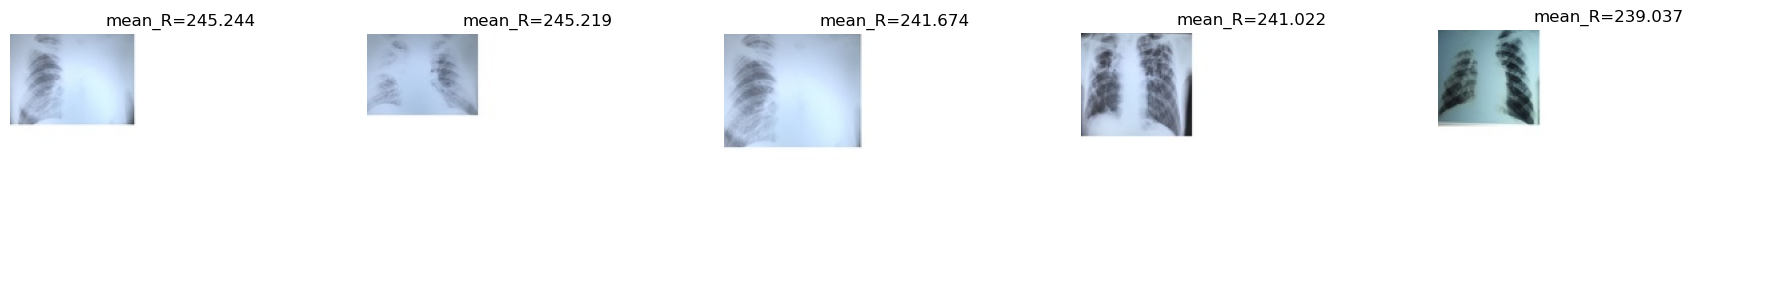

In [18]:
brightest = intensity_df.sort_values("mean_R", ascending=False).head(5) # doesn't matter which color channel

fig, axes = plt.subplots(1, 5, figsize=(18, 4))

for ax, (_, row) in zip(axes, brightest.iterrows()):
    img = cv2.imread(row["path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img)
    ax.set_title(f"mean_R={row['mean_R']:.3f}")
    ax.axis("off")

plt.tight_layout()
plt.show()

Images with highest and lowest intensity are still anatomically clear.

### Images with uniform background 
Some images are sitting in one corner of the image. I will use contour to find connected regions in image (potentially the x-ray content) to flag these images and inspect them visually. I will calculate the area ratio of the high contour region to the image area, to see how much of the x-ray content occupy the image.

In [19]:
def foreground_area_ratio_contours(path, low=15, high=240):
    img = cv2.imread(path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # foreground must be not near-black or not near-white
    fg_mask = (gray > low) & (gray < high)
    fg_mask = fg_mask.astype(np.uint8) * 255

    contours, _ = cv2.findContours(
        fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if not contours:
        return 0.0

    foreground_area = sum(cv2.contourArea(c) for c in contours)
    image_area = gray.shape[0] * gray.shape[1]

    return foreground_area / image_area

import pandas as pd

records = []
for path in image_paths:
    ratio = foreground_area_ratio_contours(path)
    records.append({
        "path": path,
        "foreground_area_ratio": ratio
    })

contour_df = pd.DataFrame(records)
contour_df.to_csv("../data/interim/image_foreground_area_ratio_contours.csv", index=False)
contour_df.head()      


,path,foreground_area_ratio
0,../data/raw/unzipped_raw_data/test/normal/norm...,0.927522
1,../data/raw/unzipped_raw_data/test/normal/norm...,0.991909
2,../data/raw/unzipped_raw_data/test/normal/norm...,0.909422
3,../data/raw/unzipped_raw_data/test/normal/norm...,0.954010
4,../data/raw/unzipped_raw_data/test/normal/norm...,0.938768


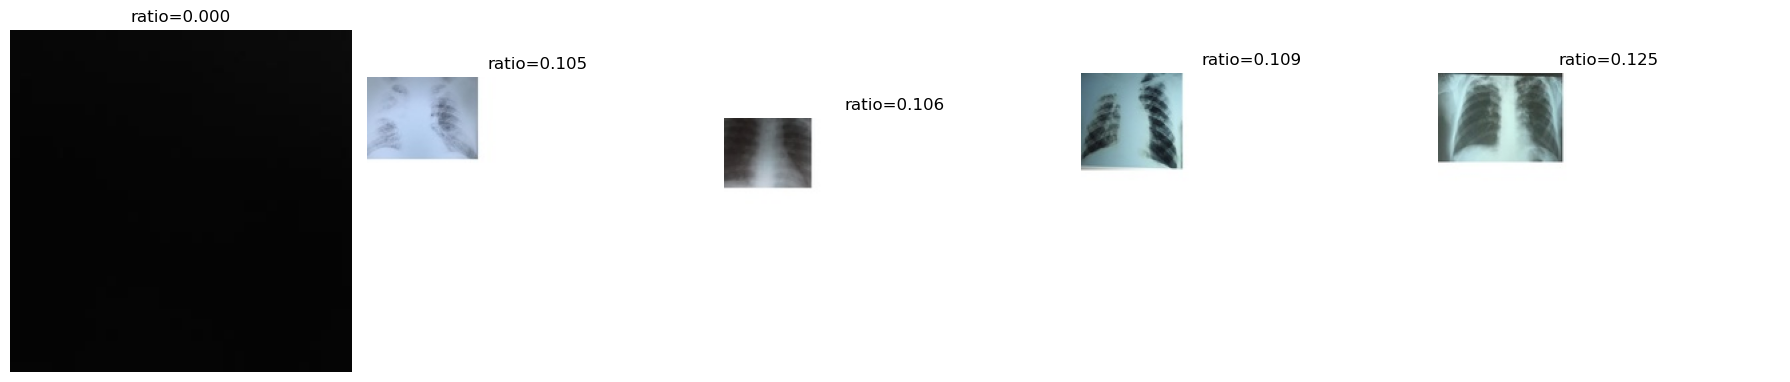

In [20]:
# 5 most background-dominated images
worst = contour_df.sort_values("foreground_area_ratio").head(5)

fig, axes = plt.subplots(1, 5, figsize=(18, 4))

for ax, (_, row) in zip(axes, worst.iterrows()):
    img = cv2.imread(row["path"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img)
    ax.set_title(f"ratio={row['foreground_area_ratio']:.3f}")
    ax.axis("off")

plt.tight_layout()
plt.show()


Only the first image will be exluded. Even though these images have the x-ray content occupying only small portion of the image surrounded by uniform background. These cases were not excluded, as the diagnostic structures were still visible, and resizing and normalization are expected to reduce the impact of background padding.

### Duplicated views

In [21]:
def left_right_ssim(path):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        return np.nan

    h, w = img.shape
    left = img[:, :w // 2]
    right = img[:, w // 2:]

    min_w = min(left.shape[1], right.shape[1])
    left = left[:, :min_w]
    right = right[:, :min_w]

    score = ssim(left, right)
    return score


DATA_DIR = Path("../data/raw/unzipped_raw_data")
image_paths = list(DATA_DIR.rglob("*.jpg"))

records = []
for path in image_paths:
    records.append({
        "path": str(path),
        "left_right_ssim": left_right_ssim(path)
    })

ssim_df = pd.DataFrame(records)
ssim_df.to_csv("../data/interim/image_left_right_ssim.csv", index=False)
ssim_df.head()

,path,left_right_ssim
0,../data/raw/unzipped_raw_data/test/normal/norm...,2.572708e-02
1,../data/raw/unzipped_raw_data/test/normal/norm...,7.918152e-09
2,../data/raw/unzipped_raw_data/test/normal/norm...,1.086188e-01
3,../data/raw/unzipped_raw_data/test/normal/norm...,5.403413e-04
4,../data/raw/unzipped_raw_data/test/normal/norm...,2.774197e-02


Several heuristics approaches were explored to identify duplicate view cases at scale; however, due to inherent anatomical symmetry in chest X-rays, no single metric reliably separated duplicated views from valid images. As diagnostic anatomy remained visible and the affected images represented a small fraction of the dataset, these samples were retained.

### Distribution of class per split
To be able to explore class distribution in general, data need to be cleaned first and unwanted images are exluded. The code below delete the files in `paths_to_delete` list and make a new copy of the clean dataset in `data/interm`. The list of files to delete are stored in `data/raw/files_to_delete.csv`. I will use this `.csv` in the automated data processing script to make this work reproducible. The majority of files are duplicated files. The rest of files are subjective judgment. 

In [24]:
# clean data first. Deleted unwanted files based on previous analysis.
len(paths_to_delete)
pd.DataFrame(paths_to_delete, columns=["path"]).to_csv(
    "../data/raw/paths_to_delete.csv",
    index=False
)


# create a new directory for deduped data
SRC_DIR = Path("../data/raw/unzipped_raw_data")
DST_DIR = Path("../data/interim/cleaned_data")

if not DST_DIR.exists():
     shutil.copytree(SRC_DIR, DST_DIR)


# Perform deletion only in the copied dataset
deleted = 0
for p in paths_to_delete:
    fp = Path(p.replace("data/raw/unzipped_raw_data", "data/interim/cleaned_data"))
    if fp.exists():
        fp.unlink()
        deleted += 1

print(f"Deleted {deleted} files from the new copy")

Deleted 11180 files from the new copy


The code cell below is fetching number of images per split per class and creating visualizations.

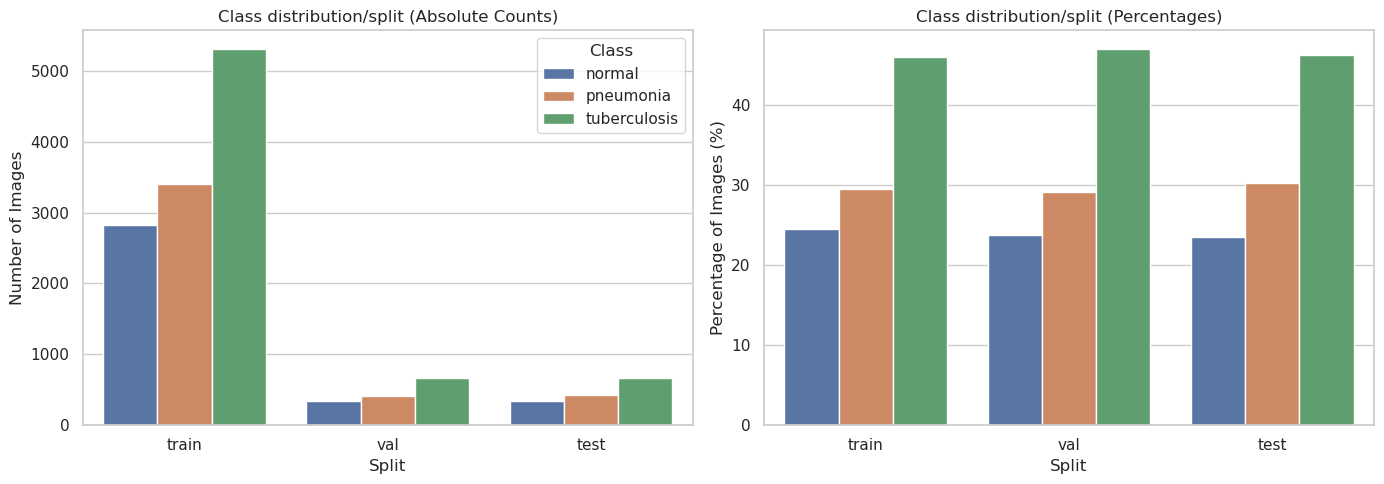

In [ ]:
DATA_DIR = Path("../data/interim/cleaned_data")

splits = ["train", "val", "test"]
classes = ["normal", "pneumonia", "tuberculosis"]

records = []

for split in splits:
    for cls in classes:
        class_dir = DATA_DIR / split / cls
        num_images = len(list(class_dir.glob("*.jpg")))
        
        records.append({
            "split": split,
            "class": cls,
            "num_images": num_images
        })

counts_df = pd.DataFrame(records)

# Save to CSV
counts_df.to_csv("../data/interim/cleaned_data/class_split_counts.csv", index=False)



# Compute percentages within each split
counts_pct_df = counts_df.copy()
counts_pct_df["percent"] = (
    counts_pct_df
    .groupby("split")["num_images"]
    .transform(lambda x: x / x.sum() * 100)
)

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# --- Plot 1: Absolute counts ---
sns.barplot(
    data=counts_df,
    x="split",
    y="num_images",
    hue="class",
    ax=axes[0]
)
axes[0].set_title("Class distribution/split (Absolute Counts)")
axes[0].set_xlabel("Split")
axes[0].set_ylabel("Number of Images")

# --- Plot 2: Percentages ---
sns.barplot(
    data=counts_pct_df,
    x="split",
    y="percent",
    hue="class",
    ax=axes[1]
)
axes[1].set_title("Class distribution/split (Percentages)")
axes[1].set_xlabel("Split")
axes[1].set_ylabel("Percentage of Images (%)")

# Handle legends (avoid duplication)
axes[0].legend(title="Class")
axes[1].legend_.remove()

plt.tight_layout()
plt.show()

Given the table/figures above, I will keep the current split. The reasons for this are:
a- the split contains all classes,
b- close proportions of each class across splits,
c- keep comparability with existing work,
d- lack of patient metadata to actually make informative re-splitting.

Having that said, there is clear class imbalance on the dataset-level (not the split-level).

### Class imbalance
Exploring class distribution across the full dataset to inform appropriate evaluation metrics.

In [ ]:
DATA_DIR = Path("../data/interim/cleaned_data")  

records = []
for img_path in DATA_DIR.rglob("*.jpg"):
    records.append({
        "path": str(img_path),
        "label": img_path.parent.name
    })

classes_df = pd.DataFrame(records)

classes_df.head()

class_distribution = (
     classes_df
    .groupby("label")
    .size()
    .reset_index(name="count")
)

class_distribution["proportion"] = (
    class_distribution["count"] / class_distribution["count"].sum()
)

class_distribution
class_distribution.to_csv("../data/interim/cleaned_data/class_distribution.csv", index=False)


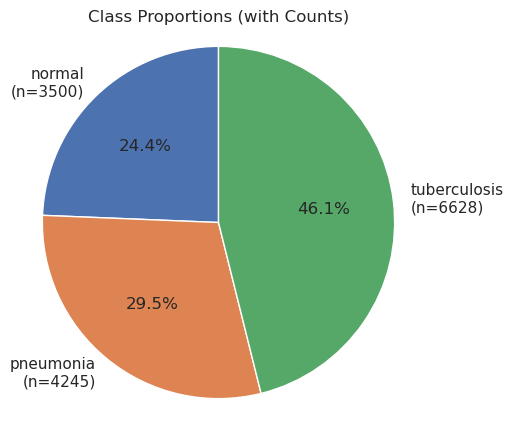

In [ ]:
plt.figure(figsize=(5, 5))
plt.pie(
    class_distribution["proportion"],
    labels=[
        f"{lbl}\n(n={cnt})"
        for lbl, cnt in zip(
            class_distribution["label"],
            class_distribution["count"]
        )
    ],
    autopct="%.1f%%",
    startangle=90
)
plt.title("Class Proportions (with Counts)")
plt.axis("equal")
plt.show()


Class distribution analysis shows mild imbalance across classes, with Tuberculosis representing the largest class (~46%) and Normal and Pneumona are close. All classes are well represented with thousands for image in each, suggesting that aggressive resampling is unnecessary; however, macro-averaged evaluation metrics is more appropriate than over-all model accuracy to ensure balanced performance across classes. Given the sensitivity of this medical diagnosis and the class imbalance, recall per class metric especially for TB and Pnemonia should be monitored to avoid costly false negative.